In [1]:
# -*- coding: utf-8 -*-
# 必要ライブラリ
import os
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import japanize_matplotlib
from statistics import mean, median,variance,stdev

## 連続した日付データ作成 date_range()
閉区間[start, end]の範囲で出力する

In [2]:
def date_range(start, end):
    for n in range((end - start).days + 1):
        yield start + timedelta(n)

# 定数

In [3]:
CORRECTS = {
    "tk": {
        "kaede": {"start": dt.date(2015, 12, 4), "end": dt.date(2015, 12, 12)},
        "icho": {"start": dt.date(2015, 11, 30), "end": dt.date(2015, 12, 11)},
    },
    "hk": {
        "kaede": {"start": dt.date(2015, 10, 29), "end": dt.date(2015, 11, 29)},
        "icho": {"start": dt.date(2015, 11, 2), "end": dt.date(2015, 11, 12)},
    },
    "is": {
        "kaede": {"start": dt.date(2015, 11, 22), "end": dt.date(2015, 12, 3)},
        "icho": {"start": dt.date(2015, 11, 4), "end": dt.date(2015, 11, 10)}
    }
}

START_DATE = dt.date(2015, 8, 15) # plotする期間
END_DATE = dt.date(2015, 12,31)
dates = [date for date in date_range(START_DATE, END_DATE)]

# 移動平均によるバースト

In [4]:
def estimate_season(counts, total_avg):
    continuous_days = 0
    for index, oneday in counts.iterrows():
        # counts.iterrows()はビューではなくコピーを返すので、直接加えても元のcountsには追加されない。
        
        if oneday['7日移動平均'] >= oneday['30日移動平均']:
            continuous_days += 1
            if oneday['前日の旬ツイート数'] >= total_avg \
                and continuous_days >= 3.5:
                    counts.at[index, '見頃判断'] = 1 
            else:
                counts.at[index, '見頃判断'] = 0
        else:
            continuous_days = 0
            counts.at[index, '見頃判断'] = 0

# F値算出<br>evaluate(result, pref, flag, dates)

In [5]:
def evaluate(result, pref, flag, dates):       
    # dates: 評価する期間
    """
    tp: true positives
    tn: true negatives
    fn: false negativess
    fp: false positives
    """
    tp, tn, fn, fp = 0, 0, 0, 0
    if flag in ["icho", "kaede"]:
        correct_period = [date for date in date_range(CORRECTS[pref][flag]['start'], \
                                                      CORRECTS[pref][flag]['end'])]
    else: 
        icho_period = [date for date in date_range(CORRECTS[pref]['icho']['start'], \
                                                      CORRECTS[pref]['icho']['end'])]
        kaede_period = [date for date in date_range(CORRECTS[pref]['kaede']['start'], \
                                                      CORRECTS[pref]['kaede']['end'])]
        
        correct_period = icho_period + kaede_period
        correct_period = list(set(correct_period))
          
    for oneday in dates:
        if oneday in correct_period:
            oneday = oneday.isoformat()
            if result.at[oneday, "見頃判断"] == 1:
                tp += 1
            elif result.at[oneday, "見頃判断"] == 0:
                tn += 1
            else:
                print("error")
        else:
            if result.at[oneday, "見頃判断"] == 1:
                fp += 1
            elif result.at[oneday, "見頃判断"] == 0:
                fn += 1
            else:
                print("error")
    
    if tp == 0:
        recall = precision = fscore = 0
    else:
        recall = tp / len(correct_period)
        precision = tp / (tp + fp)
        fscore = (2 * recall * precision) / (recall + precision)
    
    # 評価値を出す
#     print(f"[{pref}]: {flag}")
#     print(f"recall: {recall}")
#     print(f"precision: {precision}")
    print(f"{flag}: {fscore}")
    
    return recall, precision, fscore

## 見頃plot<br>plot_migoro(x, q, pref, flag)

In [6]:
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
from matplotlib.dates import date2num

def plot_migoro(x, q, pref, flag):
    
    y_correct = []
    if flag == "sonota" or flag == "koyo":
        for date in x:
            if ( CORRECTS[pref]["kaede"]['start'] <= date <= CORRECTS[pref]["kaede"]['end']
                or CORRECTS[pref]["icho"]['start'] <= date <= CORRECTS[pref]["icho"]['end']):
                y_correct.append(1)
            else:
                y_correct.append(0)
    else: 
        for date in x:
            if  CORRECTS[pref][flag]['start'] <= date <= CORRECTS[pref][flag]['end']:
                y_correct.append(1)
            else: 
                 y_correct.append(0)
                    
    figure_ = plt.figure()  # Figure作成
    figure_.text(0.2, 0.5, str(pref) + ": " + str(flag), fontsize=20)
    figure_.text(0.2, 0.4, "endo", fontsize=20)
    
    axes_ = figure_.add_subplot(111)  # Axes作成
    xaxis_ = axes_.xaxis  # XAxis取得
    
    x_numdate = date2num([
        dt.date(2015, 8, 15), 
        dt.date(2015, 9, 1), dt.date(2015, 9, 15), 
        dt.date(2015, 10, 1), dt.date(2015, 10, 15), 
        dt.date(2015, 11, 1), dt.date(2015, 11, 15), 
        dt.date(2015, 12, 1), dt.date(2015, 12, 15), dt.date(2015, 12, 31)
    ])
    
    axes_.xaxis.set_major_locator(ticker.FixedLocator(x_numdate))
    axes_.tick_params(axis='x', rotation=270)
    xaxis_.set_major_formatter(DateFormatter('%m-%d'))
    
    axes_.plot(x, y_correct, label='correct')
    axes_.plot(x, q, label='burst')
    plt.legend()
    
    fname = f"{pref}_{flag}.png"
    out_dir = f"/Users/daigo/workspace/koyo/_endo/result/"
    os.makedirs(out_dir, exist_ok=True)
    plt.savefig(out_dir + fname)
    plt.show()
    
    plt.close()

# main

In [7]:
prefectures = ["tk", "hk", "is"]
flags = ["icho", "kaede", "sonota", "koyo"]

total_path = "/Users/daigo/workspace/koyo/result/total_count/"
simple_path = "/Users/daigo/workspace/koyo/_endo/simple_count_0815to1231/"

F-score: 
tk
icho: 0.5333333333333333


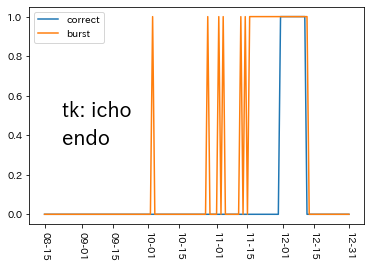

kaede: 0.25


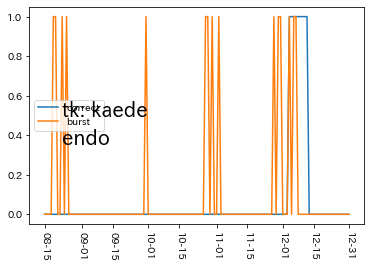

sonota: 0.47058823529411764


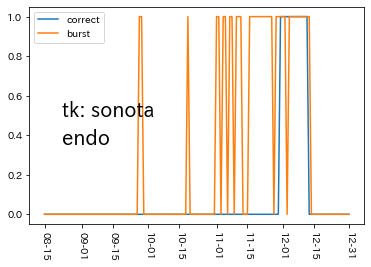

koyo: 0.52


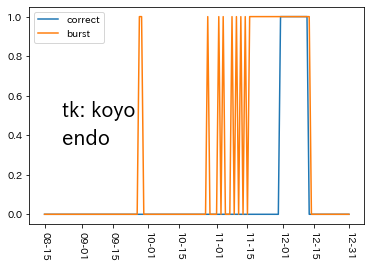

hk
icho: 0.4864864864864865


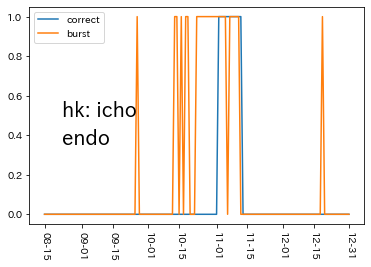

kaede: 0.05


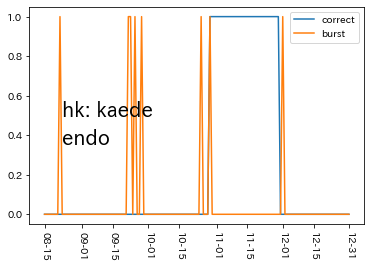

sonota: 0.03333333333333333


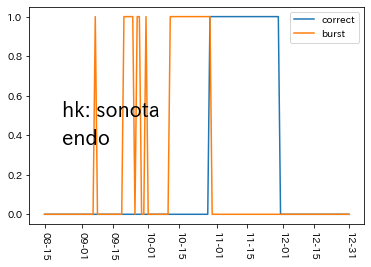

koyo: 0.06779661016949153


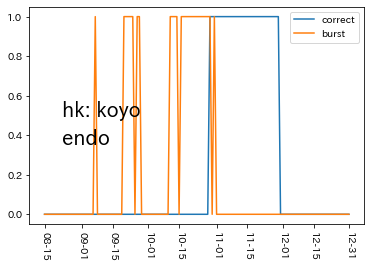

is
icho: 0


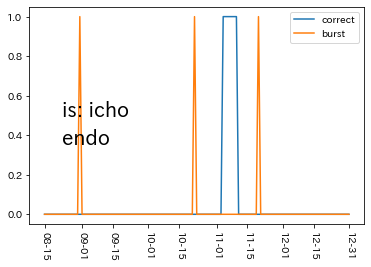

kaede: 0


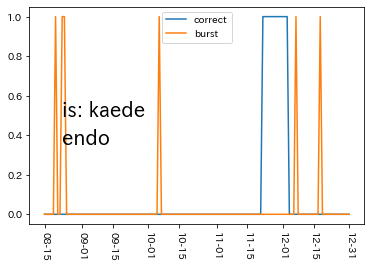

sonota: 0.5789473684210527


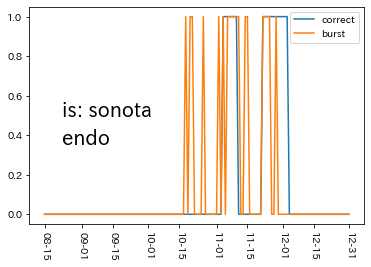

koyo: 0.5789473684210527


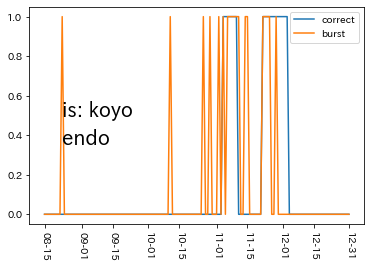

In [8]:
print("F-score: ")
for pref in prefectures:
    print(pref)
    for flag in flags:
        filename = f"{pref}_{flag}_count.txt"
        counts = pd.read_table(simple_path+filename, names=('date', '旬ツイート数'), \
                               header=None, index_col='date', parse_dates=True)
        
        # 本来なら1年移動平均だが、データ期間全体(2/17~12/31)の平均を使っている。(遠藤論文と同じ)
        total_avg = counts['旬ツイート数'].mean()

        # ただの移動平均だと、その日にちの関連ツイート数まで平均に含まれている。
        # 遠藤手法では、1日前~n日前の移動平均を用いる。なので、shift()で一行ずらしている。
        counts['前日の旬ツイート数']  = counts['旬ツイート数'].shift()
        counts['7日移動平均'] = counts['旬ツイート数'].rolling(7, min_periods=1).mean().shift()
        counts['30日移動平均'] = counts['旬ツイート数'].rolling(30, min_periods=1).mean().shift()
        
        estimate_season(counts, total_avg)
        
        counts['date'] = counts.index
        evaluate(counts[['見頃判断', 'date']], pref, flag, dates)
        plot_migoro(dates, counts['見頃判断'], pref, flag)

## plot

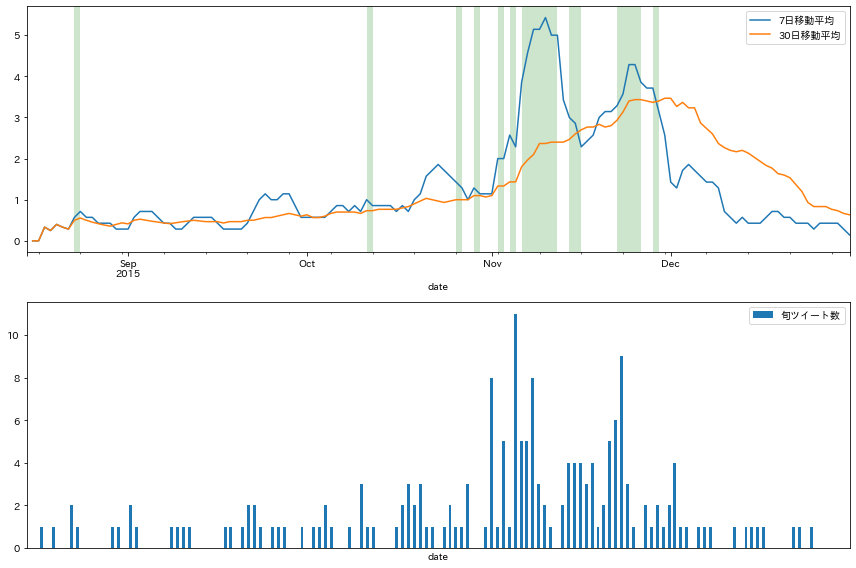

In [9]:
# 現在放置、不要

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

counts[START_DATE : END_DATE].plot(y="7日移動平均", ax=ax1)
counts[START_DATE : END_DATE].plot(y="30日移動平均", ax=ax1)
counts[START_DATE : END_DATE].plot.bar(y="旬ツイート数", ax=ax2, xticks=[]) 

for season_day in counts[START_DATE : END_DATE].query('見頃判断 == 1').index:
    td_1d = dt.timedelta(days=1)
    ax1.axvspan(season_day.date(), season_day.date() + td_1d,
           facecolor='g', edgecolor='none', alpha=.2)
    
fig.tight_layout()

# path = "./png/"
# plt.savefig(path + target + ".png")